In [49]:
from typing import Union, Tuple, Dict
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from numpy import interp
from sklearn.metrics import roc_auc_score

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

In [58]:
import torch

y_score = torch.as_tensor(y_score)

In [29]:
def compute_roc_curve(n_classes: int, y_true: np.ndarray, logits: np.ndarray):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], logits[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), logits.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    return tpr, fpr, roc_auc

In [30]:

tpr, fpr, roc_auc = compute_roc_curve(n_classes, y_test, y_score.cpu().numpy())

In [31]:
tpr

{0: array([0.        , 0.04761905, 0.14285714, 0.14285714, 0.19047619,
        0.19047619, 0.33333333, 0.33333333, 0.38095238, 0.38095238,
        0.61904762, 0.61904762, 0.66666667, 0.66666667, 0.76190476,
        0.76190476, 0.9047619 , 0.9047619 , 0.95238095, 0.95238095,
        1.        , 1.        ]),
 1: array([0.        , 0.03333333, 0.13333333, 0.13333333, 0.16666667,
        0.16666667, 0.2       , 0.2       , 0.26666667, 0.26666667,
        0.33333333, 0.33333333, 0.4       , 0.4       , 0.43333333,
        0.43333333, 0.5       , 0.5       , 0.56666667, 0.56666667,
        0.6       , 0.6       , 0.63333333, 0.63333333, 0.7       ,
        0.7       , 0.73333333, 0.73333333, 0.9       , 0.9       ,
        0.93333333, 0.93333333, 0.96666667, 0.96666667, 1.        ,
        1.        ]),
 2: array([0.        , 0.04166667, 0.125     , 0.125     , 0.25      ,
        0.25      , 0.29166667, 0.29166667, 0.33333333, 0.33333333,
        0.41666667, 0.41666667, 0.5       , 0.5    

In [59]:
def plot_roc_curve_for_class(tpr: np.ndarray,
                             fpr: np.ndarray,
                             roc_auc: np.ndarray,
                             class_idx: int,
                             class_name: str):
    """
    Plot of a ROC curve for a specific class.

    :param tpr: The true positive rate (sensitivity).
    :param fpr: The false positive rate (fall-out).
    :param roc_auc: The ROC AUC scores.
    :param class_idx: The class index.
    :param class_name: The class name.
    :return: The figure.
    """
    figure = plt.figure()
    lw = 2
    plt.plot(fpr[class_idx], tpr[class_idx], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[class_idx])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for class {0}'.format(class_name))
    plt.legend(loc="lower right")
    return figure

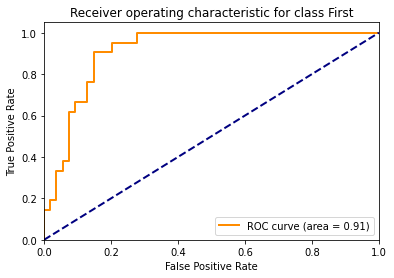

In [61]:
fig = plot_roc_curve_for_class(tpr, fpr, roc_auc, 0, "First")

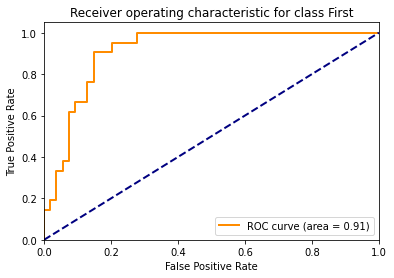

In [62]:
fig



In [52]:
def plot_multiclass_roc(tpr: np.ndarray,
                        fpr:np.ndarray,
                        roc_auc: np.ndarray,
                        class_name_lookup: Dict[int, str],
                        figsize: Tuple[int, int]) -> plt.Figure:
    """
    Compute macro-average ROC curve and ROC area.


    :param tpr: The true positive rate (sensitivity).
    :param fpr: The false positive rate (fall-out).
    :param roc_auc: The ROC AUC scores.
    :param class_name_lookup: The class name lookup dictionary by class index.
    :param figsize: The size of the figure.
    :return: The figure.
    """
    lw = 2

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_name_lookup))]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(class_name_lookup)):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= len(class_name_lookup)

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    fig = plt.figure(figsize=figsize)
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(len(class_name_lookup)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(class_name_lookup[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

    return fig

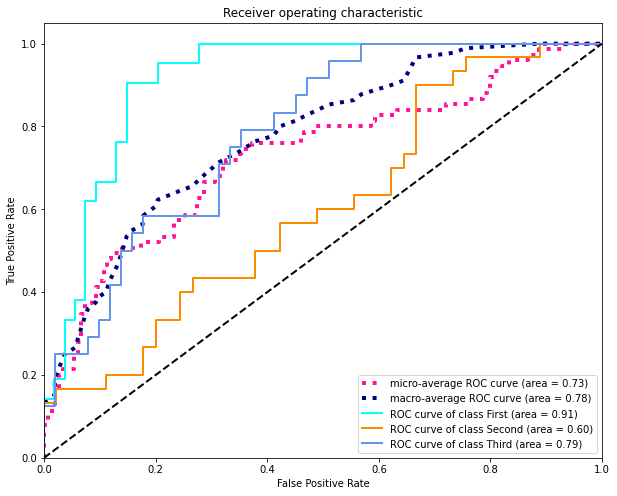

In [68]:
class_name_dict = {
    0: "First",
    1: "Second",
    2: "Third",
}

fig = plot_multiclass_roc(tpr, fpr, roc_auc, class_name_dict, (10,8))

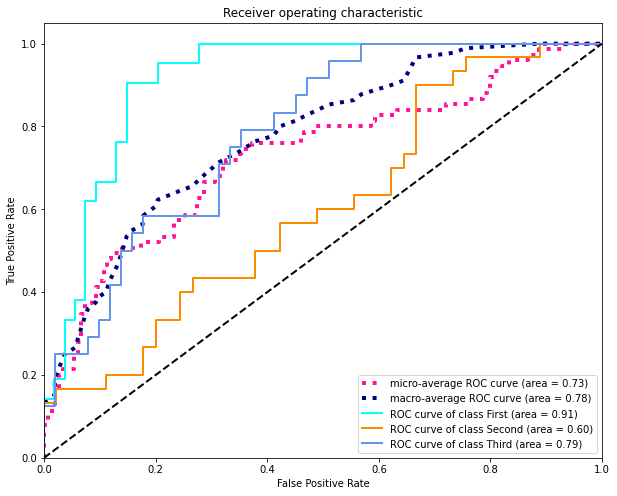

In [69]:
fig

In [70]:
y_prob = y_score.softmax(dim=1).cpu().numpy()


In [75]:
def multiclass_roc_auc_scores(y_prob: np.ndarray, y_true: np.ndarray):
    """
    ROC AUC score for multiclass classification.

    The sklearn.metrics.roc_auc_score function can be used for multi-class classification.
    The multi-class One-vs-One scheme compares every unique pairwise combination of classes.
    In this section, we calculate the AUC using the OvR and OvO schemes.
    We report a macro average, and a prevalence-weighted average

    :param y_prob: The class probabilities.
    Run softmax on the logits from your model before passing the outputs to this function.
    :param y_true: The true labels.
    :return: Macro average, and a prevalence-weighted average ROC AUC scores for OvO and OvR schemes.
    """
    macro_roc_auc_ovo = roc_auc_score(y_true, y_prob, multi_class="ovo",
                                  average="macro")
    weighted_roc_auc_ovo = roc_auc_score(y_true, y_prob, multi_class="ovo",
                                         average="weighted")
    macro_roc_auc_ovr = roc_auc_score(y_true, y_prob, multi_class="ovr",
                                      average="macro")
    weighted_roc_auc_ovr = roc_auc_score(y_true, y_prob, multi_class="ovr",
                                         average="weighted")

    return macro_roc_auc_ovo, \
           weighted_roc_auc_ovo, \
           macro_roc_auc_ovr, \
           weighted_roc_auc_ovr

In [76]:
macro_roc_auc_ovo, weighted_roc_auc_ovo, macro_roc_auc_ovr, weighted_roc_auc_ovr = multiclass_roc_auc_scores(y_prob, y_test)


print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.778881 (macro),
0.761374 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.778881 (macro),
0.761374 (weighted by prevalence)
